<hr style="border:3px solid coral"/>

# Advection in swirling flow

<hr style="border:3px solid coral"/>


The notebook solves the scalar advection equation,

\begin{equation}
q_t + \mathbf u \cdot \nabla q = 0
\end{equation}

where $\mathbf u = (u(x,y),v(x,y))$ is a specified velocity field.  This equation models, for example, the transport of a tracer field in a background flow.  

We solve this problem in a box $x \in [0,1] \times [0,1]$ over the time interval $t \in [0,T]$.  

In [1]:
%matplotlib notebook

from numpy import *
from matplotlib.pyplot import *

<hr style="border:2px solid coral"/>

## User defined input paramters

<hr style="border:2px solid coral"/>


In [2]:
# Domain [a,b]x[a,b]
a = 0
b = 1

# Final time
T_final = 2.0

# Number of grid points
N = 256

time_dependent_velocity = False

method_order = 2

###  Initial condition and velocity field

For the initial conditions, we use the function 

\begin{equation}
q(x) = \left\{\begin{array}{cc} \frac{1}{4}\left(1 + \cos\left(\frac{\pi r}{r_0}\right)\right) & r \le r_0 \\
        0 & \mbox{otherwise} 
        \end{array}\right.
\end{equation}

where $r = \sqrt{(x-x_0)^2 + (y-y_0)^2}$.  

The velocity field is given by 

\begin{eqnarray}
u(x,y) & = \sin(\pi x)^2 \; \sin(2\pi y) \\
v(x,y) & = -\sin(\pi y)^2 \; \sin(2\pi x)
\end{eqnarray}

In [3]:
# Initial conditions
x0 = 0.25     # Center of cosine bell
y0 = 0.5
r0 = 0.25      # Radius

def initial_condition(x,y):
    r2 = sqrt((x - x0)**2 + (y - y0)**2)
    r2 = abs(y-y0)
    q = where(r2 <= r0,0.25*(1 + cos(pi*r2/r0)),0)
    return q

def attenuation(t):
    if time_dependent_velocity:
        vt = cos(pi*t/T_final)
    else:
        vt = 1
        
    return vt

def velocity(x,y,t=0):
    vt = attenuation(t)
    u =  vt*sin(pi*x)**2*sin(2*pi*y)
    v = -vt*sin(pi*y)**2*sin(2*pi*x)
    return u,v

<hr style="border:2px solid coral"/>

## Numerical parameters

<hr style="border:2px solid coral"/>

Numerical parameters include mesh width $h$ and time step $\Delta t$. 


In [4]:
# mesh width
h = (b-a)/N

# Compute a stable time step.  

# Donor cell upwind is only stable for cfl < 0.5 (we aren't using transverse waves)
cfl_desired = 0.45

velmax = 1  # Maximum velocity in velocity field.
dt_est = cfl_desired*h/velmax
M = int(ceil(T_final/dt_est)) + 1
dt = T_final/M

<hr style="border:2px solid coral"/>

## Generate the mesh and the velocity field

<hr style="border:2px solid coral"/>


In [5]:
# Nodes
xe = ye = linspace(a,b,N+1)

# Cell centers
xc = yc = xe[:-1] + h/2

# Cell-centered mesh for q (needed for plotting)
[xm,ym] = meshgrid(xc,xc,indexing='ij') 

# Staggered grid at x,y faces (for velocities)
[xem,ycm] = meshgrid(xe,yc,indexing='ij')
[xcm,yem] = meshgrid(xc,ye,indexing='ij')

### Plot velocity field

In [6]:
if N == 16:
    
    from itertools import product
    # Velocity in each of the four quadrants 
    xv = [0.25,0.75]
    yv = [0.25,0.75]
    xy = product(xv,yv)
    print("Velocity field at centers of four quadrants in [0,1]x[0,1]:",end="\n\n")
    for x,y in xy:
        u,v = velocity(x,y)
        print(f"(x,y) = ({x:4.2f},{y:5.2f})    (u,v) = ({u:5.2f},{v:6.2f})")    
        
        
    figure(1)
    clf()

    set_cmap('jet')
    
    q = initial_condition(xm,ym)
    extent=[xe[0],xe[-1],ye[0],ye[-1]]
    imshow(q.T,vmin=-0.1,vmax=0.5,extent=extent,origin='lower');
    
    uvel,vvel = velocity(xm,ym)
    quiver(xm,ym,uvel,vvel,color='w')

    title('Velocity field')
    
    gca().set_xticks(xe[::8])
    gca().set_yticks(ye[::8])
    grid()
    
    gca().set_aspect('equal');
else:
    print("To see the velocity field, set N=16")

To see the velocity field, set N=16


### Plot the initial conditions

<IPython.core.display.Javascript object>


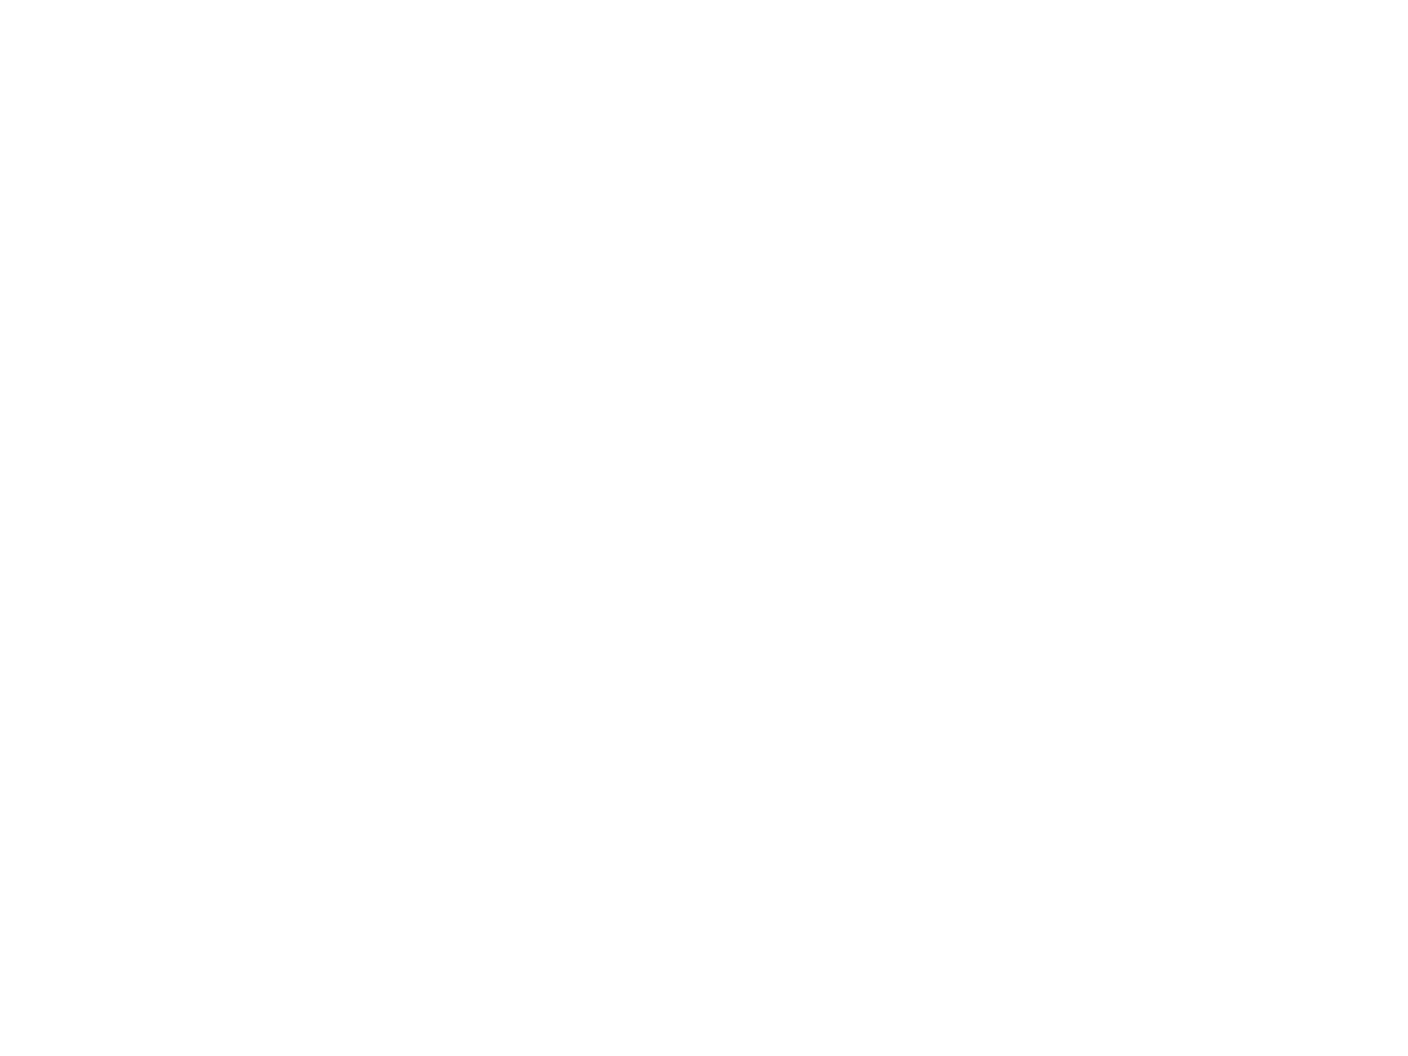

In [7]:
# Plot initial conditions
figure(2)
clf()

set_cmap('jet')

q = initial_condition(xm,ym)
extent=[xe[0],xe[-1],ye[0],ye[-1]]
imshow(q.T,vmin=-0.1,vmax=0.4,extent=extent,origin='lower');

gca().set_aspect(1)

title('Initial Conditions q(x,0)',fontsize=16)
xlabel('x')
ylabel('y');

<hr style="border:2px solid coral"/>

##  Solution

<hr style="border:2px solid coral"/>

This the main loop that updates the solution by updating the solution $q(x,t)$ in time.  We illustrate the Lax-Wendroff method 


In [8]:
# Upwinded velocities in at x and y faces
def upwind_velocities(t=0):
    uvelx,vvelx = velocity(xem,ycm,t)
    uvely,vvely = velocity(xcm,yem,t)
    
    # Precompute part of correction term
    cxx = 0.5*abs(uvelx)*(1 - abs(uvelx)*dt/h)
    cyy = 0.5*abs(vvely)*(1 - abs(vvely)*dt/h)
    
    up = where(uvelx > 0,uvelx,0)
    um = where(uvelx < 0,uvelx,0)

    vp = where(vvely > 0,vvely,0)
    vm = where(vvely < 0,vvely,0)
        
    return up,um,vp,vm,cxx,cyy


<IPython.core.display.Javascript object>


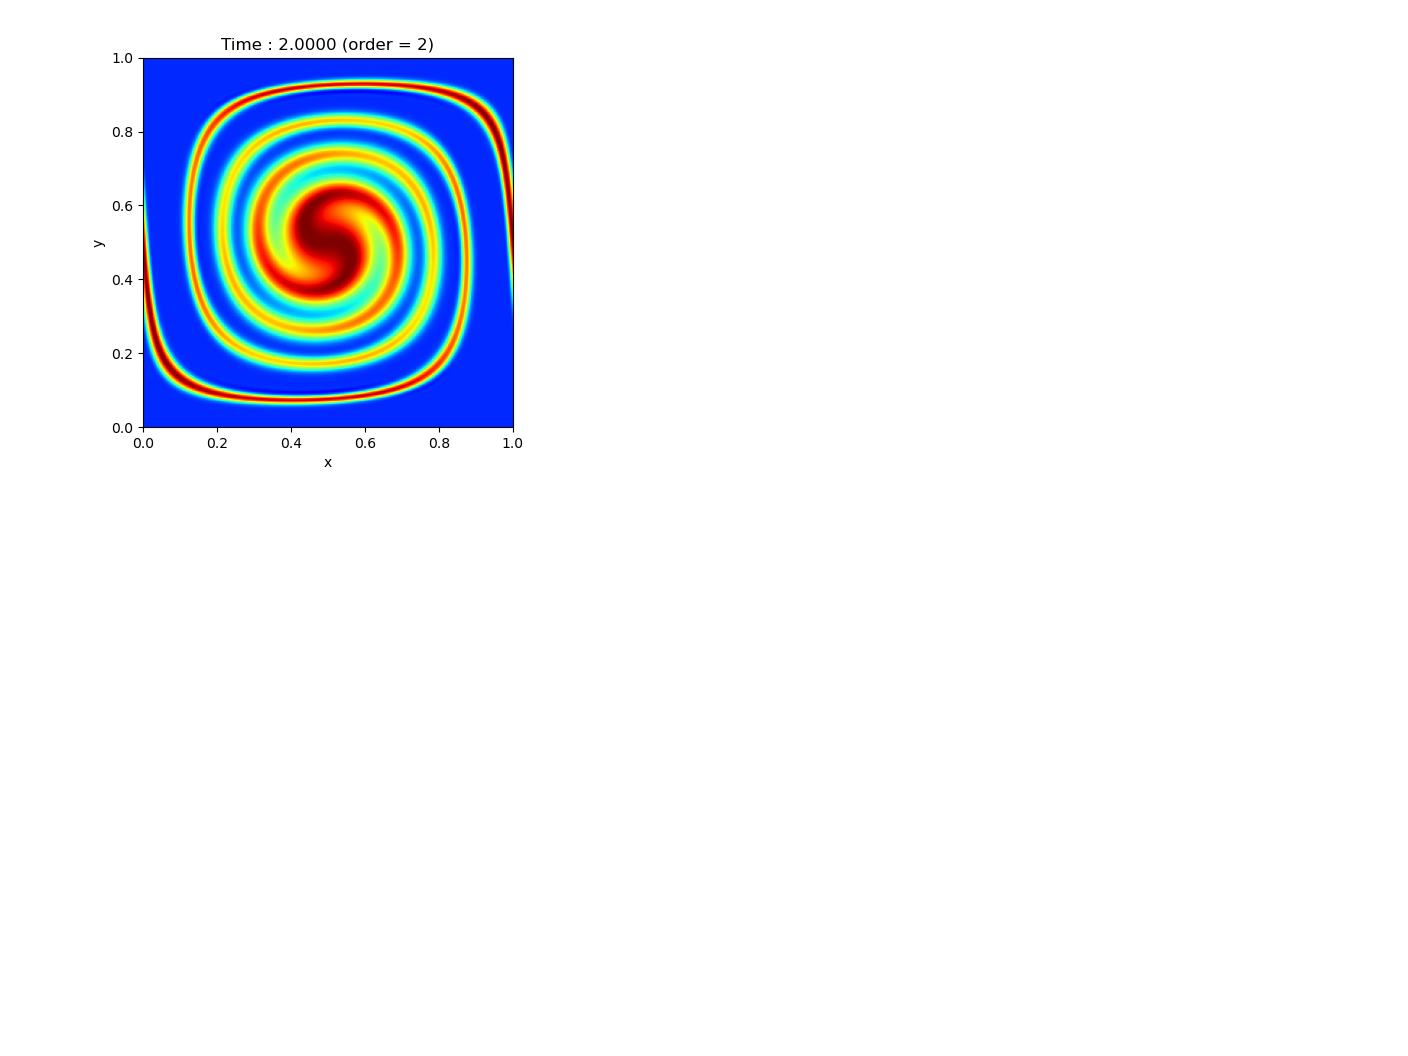

N=256 M=1139 dt=0.0017559262510975
qmax=5.0503524279690104e-01 qmin=-2.4890568329202473e-02


In [9]:
%matplotlib notebook

fig = figure(3)
clf()

# Evaluate initial conditions
[xm,ym] = meshgrid(xc,yc,indexing='ij')
q = initial_condition(xm,ym)

# Plot initial solution and store handle
im = imshow(q.T,vmin=-0.1,vmax=0.5,extent=extent,origin='lower');

# Add title, axis labels, etc
htitle = title('Time : {:.4f}'.format(0))
xlabel('x')
ylabel('y')

# Make axis square
gca().set_aspect(1)

fig.canvas.draw() 

# Beginning time stepping
second_order = method_order == 2


if not time_dependent_velocity:
    up,um,vp,vm,cxx_coeff,cyy_coeff = upwind_velocities()


# Use zero boundary conditions
q_ext = zeros((N+2,N+2))

# Number of time steps
t = 0
for n in range(0,M):
    t = t + dt
    
    if time_dependent_velocity:
        up,um,vp,vm,cxx_coeff,cyy_coeff = upwind_velocities(t)
    
    
    # Assume 0 at boundary
    q_ext[1:-1,1:-1] = q
    
    # X-Sweep
    waves_x = q_ext[1:,1:-1] - q_ext[:-1,1:-1]
    
    # Compute fluctuations
    apdq = up*waves_x
    amdq = um*waves_x
    if second_order:
        cxx = cxx_coeff*waves_x
        apdq -= cxx
        amdq += cxx

    # Y-Sweep
    waves_y = q_ext[1:-1,1:]- q_ext[1:-1,:-1]
    bpdq = vp*waves_y
    bmdq = vm*waves_y
    if second_order:
        cyy = cyy_coeff*waves_y
        bpdq -= cyy
        bmdq += cyy
    
    q = q - dt/h*(apdq[:-1,:] + amdq[1:,:]) - dt/h*(bpdq[:,:-1] + bmdq[:,1:])              
        
    im.set_data(q.T)

    # Update title with new time
    htitle.set_text('Time : {:.4f} (order = {:d})'.format(t,method_order))
    
    # Make axis square
    gca().set_aspect(1)

    # Refresh plot
    
    fig.canvas.draw()        


print(f"{N=:d} {M=:d} {dt=:.16f}")
qmax = q.max()
qmin = q.min()
print(f"{qmax=:20.16e} {qmin=:20.16e}")

<hr style="border:3px solid coral"/>

# Advection in swirling flow (in C)

<hr style="border:3px solid coral"/>


We can implement the code above in C, using 2d arrays in C. 

In [10]:
%reset -f

In [4]:
%matplotlib notebook

from numpy import *
from matplotlib.pyplot import *

## The goal of the project is to parallelize the code below

In [5]:
%%file advect_all_2d.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

Overwriting advect_all_2d.c


In [115]:
%%file wpa.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "advect_all_2d.c"


double wpa_update(int N,double dt, double h, double ** uvel, double **vvel,  
                  double** q, int order)
{
    
    double **apdq = allocate_2d(N+1,N,0);
    double **amdq = allocate_2d(N+1,N,0);

    double **bpdq = allocate_2d(N,N+1,0);
    double **bmdq = allocate_2d(N,N+1,0);
    
    // # X-sweep
    double uvmax = 0;
    for(int i = 0; i < N+1; i++)
        for(int j = 0; j < N; j++)
        {
            double wave = q[i][j] - q[i-1][j];
            //printf("q[%d][%d] = %f, q[%d][%d] = %f, wave = %f\n",i,j,q[i][j],i-1,j,q[i-1][j],wave);
            double u = uvel[i][j];
            //printf("uvel[%d][%d] = %f\n",i,j,uvel[i][j]);
            apdq[i][j] = fmax(u,0)*wave;
            amdq[i][j] = fmin(u,0)*wave;
            
            if (order == 2)
            {
                double cxx = 0.5*fabs(u)*(1 - dt*fabs(u)/h);
                apdq[i][j] -= cxx*wave;
                amdq[i][j] += cxx*wave;
            }
            uvmax = fmax(uvmax,fabs(u));
        }

    
    // # Y-sweep
    for(int i = 0; i < N; i++)
        for(int j = 0; j < N+1; j++)
        {
            double wave = q[i][j] - q[i][j-1];
            double v = vvel[i][j];
            //printf("vvel[%d][%d] = %f\n",i,j,vvel[i][j]);
            bpdq[i][j] = fmax(v,0)*wave;
            bmdq[i][j] = fmin(v,0)*wave;
            
            if (order == 2)
            {
                double cyy = 0.5*fabs(v)*(1 - dt*fabs(v)/h);
                bpdq[i][j] -= cyy*wave;
                bmdq[i][j] += cyy*wave;
            }
            uvmax = fmax(uvmax,fabs(v));
        }
    
    for(int i = 0; i < N; i++)
        for (int j = 0; j < N; j++)
            {
                q[i][j] -= dt/h*(apdq[i][j] + amdq[i+1][j] + bpdq[i][j] + bmdq[i][j+1]); 
                //printf("q[%d][%d] = %f\n",i,j,q[i][j]);
            }
                   
    
    free_2d(&apdq,0);
    free_2d(&amdq,0);
    free_2d(&bpdq,0);
    free_2d(&bmdq,0);
    
    double cflmax = dt*uvmax/h;
    return cflmax;
}

Overwriting wpa.c


In [119]:
%%file advect.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "wpa.c"

double initial_condition(double x, double y)
{
    double y0 = 0.5;
    double r0 = 0.2;
    double r = fabs(y - y0);    
    if (r <= r0)
        return 0.25*(1 + cos(M_PI*r/r0));
    else
        return 0;
}

void velocity(double x, double y, double *u, double *v)
{
    *u = pow(sin(M_PI*x),2)*sin(2*M_PI*y);
    *v = -pow(sin(M_PI*y),2)*sin(2*M_PI*x);
}


int main(int argc, char** argv)
{
    int N = (argc == 2) ? atoi(argv[1]) : 64;
    
    // # Domain
    double a = 0, b = 1;
    double Tfinal = 2;
    
    int prt = 0;
    
    int method_order = 2;
    
    // # Arrays - Use cell centered mesh
    double **q = allocate_2d(N,N,1);
    double **uvel = allocate_2d(N+1,N,0);
    double **vvel = allocate_2d(N,N+1,0);

    // # Edges (xe) and centers (xc)
    double *xe = allocate_1d(N+1,1);
    double *xc = allocate_1d(N,1);
    
    // # Set up mesh;  include ghost cell values
    double h = (b-a)/N;    
    for(int i = -1; i < N+1; i++)
    {
        xe[i] = a + i*h;
        xc[i] = a + (i+0.5)*h;
    }
    xe[N+1] = b + h;

    // # Initialize q
    for(int i = -1; i < N+1; i++)
        for(int j = -1; j < N+1; j++)   // # initialize ghost cells
            q[i][j] = initial_condition(xc[i],xc[j]);
    
    // # Get u velocities at centes of edges of x faces
    double vvelx; // # not used at x-face
    for(int i = 0; i < N+1; i++)
        for(int j = 0; j < N; j++)            
            velocity(xe[i],xc[j],&uvel[i][j],&vvelx);

    // # Get v velocities at centesr of edges of y faces
    double uvely; // # not used at x-face
    for(int i = 0; i < N; i++)
        for(int j = 0; j < N+1; j++)            
            velocity(xc[i],xe[j],&uvely,&vvel[i][j]);
    
    
    // # Compute a time step
    double cfl = 0.45;
    double uvmax = 1;
    double dt_est = cfl*h/uvmax;
    int M = ceil(Tfinal/dt_est) + 1;
    double dt = Tfinal/M;
    
    FILE* fout = fopen("advect.dat","wb");       
    fwrite(&N,sizeof(int),1,fout);    
    fwrite(&M,sizeof(int),1,fout);
    fwrite(&method_order,sizeof(int),1,fout);
    fwrite(&a,sizeof(double),1,fout);
    fwrite(&b,sizeof(double),1,fout);
    fwrite(&dt,sizeof(double),1,fout);
    
    // # write out initial condition
    double t = 0;
    fwrite(&t,sizeof(double),1,fout);
    for(int i = 0; i < N; i++)
        fwrite(q[i],sizeof(double),N, fout);             
    
   
    for(int n = 0; n < M; n++)
    {
        
        // # Update solution
        double cflmax = wpa_update(N, dt, h, uvel, vvel,  q, method_order);
        
        if (prt)
            printf("%12.4f %8.4f\n",t,cflmax);
        
        // # Write out current solution
        t += dt;
        fwrite(&t,sizeof(double),1,fout);
        for(int i = 0; i < N; i++)
            fwrite(q[i],sizeof(double),N, fout);             
    }        

    fclose(fout);
    
    free_2d(&q,1);
    free_2d(&uvel,0);
    free_2d(&vvel,0);
    free_1d(&xe,1);
    free_1d(&xc,1);
    
    return 0;
}    

Overwriting advect.c


In [120]:
%%bash

rm -rf advect.o advect

rm -rf advect.dat

gcc -o advect advect.c

./advect 32

In [121]:
import os

fout = open("advect.dat","rb")
N,M, = fromfile(fout,dtype=int32,count=2)
fout.close()

stats = os.stat("advect.dat")
print(f"File size          : {stats.st_size:d} bytes ({stats.st_size/1024:.2f} kB)")

esize = 3*4 + 8*(3 + (M+1)*(N**2+1))
print(f"Expected file size : {esize:d} bytes")

File size          : 1189036 bytes (1161.17 kB)
Expected file size : 1189036 bytes


<IPython.core.display.Javascript object>


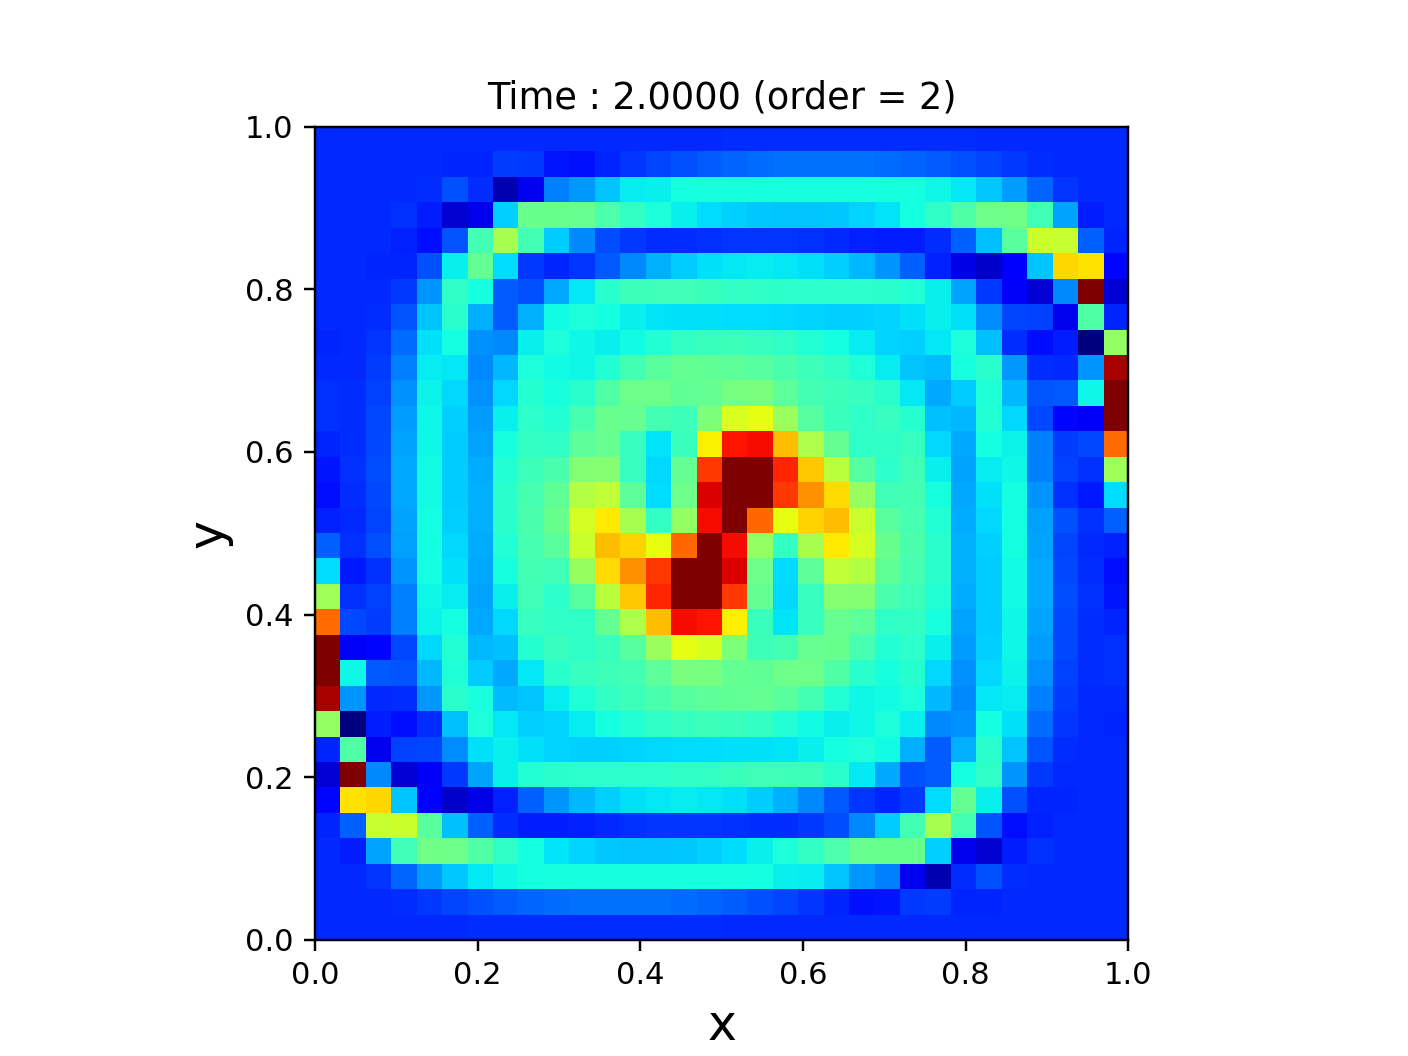

N=32 M=144 dt_step=0.0138888888888889
qmax=6.3726032572123004e-01 qmin=-2.4448248703823633e-01


In [122]:
fig = figure(4)
clf()

set_cmap('jet')


dt = dtype([('N',int32),\
            ('M',int32), \
            ('order',int32), \
            ('a',float64),\
            ('b',float64),
            ('dt',float64)])

fout = open("advect.dat","rb")
N,M,method_order,a,b,dt_step = fromfile(fout,dtype=dt, count=1)[0]

dt1 = dtype([('t',float64),('q',float64,N*N)])
t,q = fromfile(fout,dtype=dt1,count=1)[0]
q = reshape(q,(N,N))


# Plot initial solution and store handle
extent = [a,b,a,b]
im = imshow(q.T,vmin=-0.1,vmax=0.5,extent=extent,origin='lower');

# Add title, axis labels, etc
htitle = title('Time : {:.4f}'.format(0))
xlabel('x',fontsize=16)
ylabel('y', fontsize=16)

# Make axis square
gca().set_aspect(1)

fig.canvas.draw() 

pause(0.1)

for i in range(M):
    t,q = fromfile(fout,dtype=dt1,count=1)[0]
    
    q = reshape(q,(N,N))

    im.set_data(q.T)
    
    # Update title with new time
    htitle.set_text('Time : {:.4f} (order = {:d})'.format(t,method_order))
    
    # Make axis square
    gca().set_aspect(1)
    
    fig.canvas.draw()
    
    pause(0.01)
    
fout.close()    



print(f"{N=:d} {M=:d} {dt_step=:.16f}")
qmax = q.max()
qmin = q.min()
print(f"{qmax=:20.16e} {qmin=:20.16e}")

Compare output to Python run : 

    First order
    N=32 M=144 dt=0.0138888888888889
    qmax=4.0304806833014045e-01 qmin=5.2286396253711947e-18
    
    Second order
    N=32 M=144 dt=0.0138888888888889
    qmax=6.3384402354059100e-01 qmin=-1.4270168715649478e-01



In [ ]:
/* No-flux boundary conditions */
        for(int j = 0; j <= Ny; j++)
        {
            q[-1][j]   = q[1][j];
            q[Nx+1][j] = q[Nx-1][j];
        }
        for(int i = 0; i <= Nx; i++)
        {
            q[i][-1]   = q[i][1];
            q[i][Ny+1] = q[i][Ny-1];
        }